In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

import process

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_bert = True

# Baseline Ridge Regression Encoding Model

In [3]:
X_train, X_test, Y_train, Y_test, mask = process.load_data(use_bert_embeddings=use_bert,
                                                           keep_hrf_shape=False, make_validation_set=False)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [4]:
# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(X_train.numpy(), Y_train.numpy(), X_test.numpy(), Y_test.numpy(),
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

MSE: 0.98920, MC: 9.242%


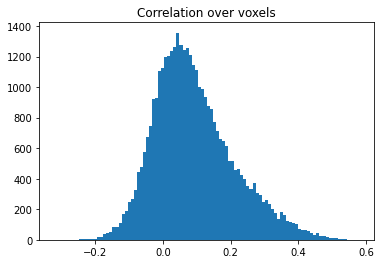

(0.9891954660415649, 0.09241839498281479)

In [5]:
Y_test_pred = X_test@torch.from_numpy(wt).float()
process.show_stats(Y_test, Y_test_pred, show_vox_corr_hist=True)

# Deep Encoding Models

In [6]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, mask = process.load_data(use_bert_embeddings=use_bert, keep_hrf_shape=True, make_validation_set=True)
X_train, X_val, X_test, Y_train, Y_val, Y_test = [x.to(device) for x in 
                                                  [X_train, X_val, X_test, Y_train, Y_val, Y_test]]
X_train = torch.cat([X_train, X_val], dim=0)
Y_train = torch.cat([Y_train, Y_val], dim=0)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [7]:
def train_model(model, opt, X_train, Y_train, bs=500, epochs=3):
    all_idxs = range(len(X_train))

    for epoch_idx in tqdm(range(epochs)):
        all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
        for batch_idxs in (all_batch_idxs):
            X_batch = X_train[batch_idxs]
            Y_batch = Y_train[batch_idxs]
            Y_batch_pred = model(X_batch)

            se, voxcorrs = process.calc_stats(Y_batch, Y_batch_pred)
    #         loss = se.mean()
            loss = -voxcorrs.mean()

            Y_test_pred = model(X_test)
            loss_test = (Y_test-Y_test_pred).pow(2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            loss = loss.detach()

    #     mse_train, corr_train = process.calc_stats(Y_batch.detach(), model(X_batch).detach())
    #     mse_val, corr_val = process.calc_stats(Y_val.detach(), model(X_val).detach())

        if epoch_idx%1==0:
            print('Training set')
            process.show_stats(Y_batch, Y_batch_pred)
            print('Validation set')
            process.show_stats(Y_val, model(X_val))
            print('Testing set')
            process.show_stats(Y_test, model(X_test))
            print()
            print()
        del Y_batch_pred, se, voxcorrs, loss

In [8]:
class AKModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_in, d_out= np.prod(X_train.shape[-2:]), Y_train.shape[-1]
        self.linear = torch.nn.Linear(d_in, d_out)
#         self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, d_out))
        
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
                                         torch.nn.Linear(1000, d_out))
        
        self.deep2 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
        self.deep3 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
    def forward(self, X):
#         Y = self.linear(X)
#         Y = self.linear(X) + self.deep1(X) + self.deep2(X) + self.deep3(X)
        X = X.reshape(X.shape[0], -1)
        Y = self.deep1(X) + self.deep2(X) + self.deep3(X)
#         Y = self.deep1(X) + self.deep3(X)
        return Y

class HRFAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_in, d_out= X_train.shape[-2], Y_train.shape[-1]
        self.mask = torch.nn.Sequential(torch.nn.Linear(d_in*4, 100),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(100, 4),
                                         torch.nn.Softmax(dim=-1))
        
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 4000),
                                         torch.nn.Linear(4000, d_out))
        
        
        self.deep2 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
#         self.attmod = torch.nn.Parameter(torch.randn(4, 37226)*1e-2)
        
        
    def forward(self, X):
        X = X.permute(0,2,1) # N, hrf, D_in
#         print(X.shape)
#         X1 = X.reshape(-1, X.shape[-1]) # N*hrf, D_in
#         print(X1.shape)
        X_hrfflat = X.reshape(X.shape[0], -1) # N, hrf*D_in
#         print(X_hrfflat.shape)
        Y = self.deep1(X)
        att = self.mask(X_hrfflat)
        Y = (Y*att[..., None]).sum(dim=-2)
#         att = torch.softmax(self.attmod, dim=-2)
#         Y = (Y*att).sum(dim=-2)
        return Y

162906376


Training set
MSE: 1.50132, MC: 3.381%
Validation set
MSE: 1.65210, MC: 6.680%
Testing set
MSE: 1.77904, MC: 4.363%


Training set
MSE: 1.70737, MC: 17.336%
Validation set
MSE: 1.82760, MC: 14.800%
Testing set
MSE: 2.20164, MC: 7.699%


Training set
MSE: 1.52505, MC: 26.099%
Validation set
MSE: 1.60668, MC: 21.282%
Testing set
MSE: 1.98733, MC: 9.443%



MSE: 1.98733, MC: 9.443%


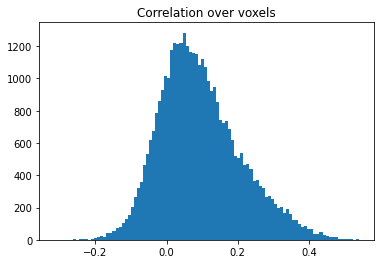

(1.9873270988464355, 0.09443218261003494)

In [9]:
torch.manual_seed(0)
model = AKModel().to(device)
model(X_test)
print(np.sum([p.numel() for p in model.parameters()]))
opt = torch.optim.Adam(model.parameters(), lr=8e-4)
train_model(model, opt, X_train, Y_train, epochs=3)
process.show_stats(Y_test, model(X_test), show_vox_corr_hist=True)

156171756


Training set
MSE: 1.08387, MC: 2.687%
Validation set
MSE: 1.12898, MC: 6.901%
Testing set
MSE: 1.15867, MC: 6.118%


Training set
MSE: 1.00308, MC: 16.901%
Validation set
MSE: 1.06171, MC: 15.312%
Testing set
MSE: 1.15810, MC: 8.325%


Training set
MSE: 0.90567, MC: 26.530%
Validation set
MSE: 0.97938, MC: 22.073%
Testing set
MSE: 1.09252, MC: 9.683%



MSE: 1.09252, MC: 9.683%


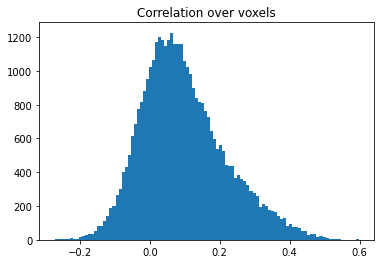

(1.0925171375274658, 0.09682520478963852)

In [10]:
torch.manual_seed(0)
model = HRFAttention().to(device)
model(X_test)
print(np.sum([p.numel() for p in model.parameters()]))
opt = torch.optim.Adam(model.parameters(), lr=4e-4)
train_model(model, opt, X_train, Y_train, epochs=3)
process.show_stats(Y_test, model(X_test), show_vox_corr_hist=True)

In [11]:
# model = torch.nn.Sequential(torch.nn.Linear(delRstim.shape[-1], mask.sum())).to(device)

# opt = torch.optim.SGD(model.parameters(), lr=3e1, weight_decay=1e-4)
# opt = torch.optim.SGD(model.parameters(), lr=6e1)